In [24]:
from z3 import *
import numpy as np
from itertools import product
from skimage.morphology import label
from scipy.ndimage import measurements
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import time
import warnings
warnings.filterwarnings("ignore", message="Please use `label` from the `scipy.ndimage` namespace")
warnings.filterwarnings("ignore", message="Please use `sum` from the `scipy.ndimage` namespace")

In [25]:
import numpy as np

In [26]:
grid = np.array([[  0,  0,  0,  0,  5,  0,  0,  0,  0],
                 [  0,  0,  0,  4,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  1,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [  0,  0,  0,  0,  0,  8,  0,  0,  0],
                 [  0,  0,  0,  0,  9,  0,  0,  0,  0]], dtype=int)

In [27]:
#grid = np.array([[  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0],
#                 [  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int)

In [28]:
def make_hooks(n: int) -> np.ndarray:
    matrix = np.ones((n, n), dtype=int) * (2*n -1)
    matrix[1:,1:] = 0
    return [np.rot90(matrix, i) for i in range(4)]

hook_17, hook_15, hook_13, hook_11, hook_9, hook_7, hook_5, hook_3 = \
    make_hooks(9), make_hooks(8), make_hooks(7), make_hooks(6), make_hooks(5), make_hooks(4), make_hooks(3), make_hooks(2)
    
orthagonal = lambda i, j, N: [(i+di, j+dj) for (di,dj) in [(0,1),(1,0),(0,-1),(-1,0)] if 0<=i+di<N and 0<=j+dj<N]

def hook_constraint(hook_number: int, board: np.ndarray, N: int) -> PbEq:
    hook = dict[int, list]({17: hook_17, 15: hook_15, 13: hook_13, 11: hook_11, 9: hook_9, 7: hook_7, 5: hook_5, 3: hook_3}).get(hook_number)
    shift = N+1 - (hook_number + 1) // 2
    conditions = list[And]()
    for shift_i, shift_j, h in product(range(shift), range(shift), hook):
        conditions.append(And([board[i+shift_i][j+shift_j]==e for (i,j),e in np.ndenumerate(h) if e]))
    return PbEq([(cond, 1) for cond in conditions], 1)

In [29]:

start = time.time()
N = len(grid)
s = Solver()
Y = np.array(IntVector("y", N**2), dtype=object).reshape((N,N)) # This is for the actual values
X = np.array(IntVector("x", N**2), dtype=object).reshape((N,N)) # Y is for the L-stuff

# Adding the givens
s += [X[i][j]==e for (i,j),e in np.ndenumerate(grid) if e!=0]

# I assume this is the no 2*2 logic 
# Actually not sure what this does
# s += [sum([X[i][j] for (i,j) in orthagonal(i, j, N)]) == grid[i][j] for (i,j),e in np.ndenumerate(grid) if e!=0]

# Why am I adding my own 2*2 logic
s += [
    Or(X[i][j] == 0,
       X[i+1][j] == 0,
       X[i][j+1] == 0,
       X[i+1][j+1] == 0)
    for i in range(N-1) for j in range(N-1)
]
#
#

s += [And(val >= 0, val <= 9) for val in X.ravel()] # I assume this is the 0 to 9 constraint
s += [And(val >= 1, val <= 17) for val in Y.ravel()] # I assume this is the length
# s += Or([val==1 for val in Y.ravel()]) # I assume this garentees one 1

# This makes it such that there are 9 9s, 8 8s, etc
s += [PbEq([(X[i][j] == n, 1) for (i,j),_ in np.ndenumerate(X)], n) for n in range(1, N+1)] 


In [30]:
#s += [PbEq([(X[i][j] == n, 1) for (i,j),_ in np.ndenumerate(X)], n) for n in range(1, N+1)]
s += [Implies(X[i][j]!=0, Or([X[ni][nj]!=0 for (ni,nj) in orthagonal(i, j, N)])) for (i,j),_ in np.ndenumerate(X)]

for hook_number in [17, 15, 13, 11, 9, 7, 5, 3]:
    s += hook_constraint(hook_number=hook_number, board=Y, N=N)
    
X17, X15, X13, X11, X9, X7, X5, X3 = Ints("x17 x15 x13 x11 x9 x7 x5 x3")
s += Distinct([X17, X15, X13, X11, X9, X7, X5, X3])

y_to_x_mapping = dict[int, list]({17: X17, 15: X15, 13: X13, 11: X11, 9: X9, 7: X7, 5: X5, 3:X3})
for y_value, x_variable in y_to_x_mapping.items():
    s += [Implies(Y[i][j]==y_value, Or(X[i][j]==x_variable, X[i][j] == 0)) for (i,j),_ in np.ndenumerate(Y)]

In [31]:
col = 2  
s += [Or([
    And(
        X[row][col] == 3,
        And([X[r][col] == 0 for r in range(row+1, N)])
    )
    for row in range(N)
])]

col = 6
s += [Or([
    And(
        X[row][col] == 7,
        And([X[r][col] == 0 for r in range(0, row)])  
    )
    for row in range(N)
])]

row = 3
s += [Or([
    And(
        X[row][col] == 6,
        And([X[row][c] == 0 for c in range(col)]) if col > 0 else True
    )
    for col in range(N)
])]

row = 5
s += [Or([
    And(
        X[row][col] == 2,
        And([X[row][c] == 0 for c in range(col+1, N)]) if col < N-1 else True
    )
    for col in range(N)
])]

In [32]:
# Specify

SHAPES = [
    [(0,1), (1,0), (1,1), (1,2), (2,0)],   # F
    [(0,0), (1,0), (2,0), (3,0), (4,0)],   # I
    [(0,0), (1,0), (2,0), (3,0), (3,1)],   # L
    [(0,0), (1,0), (2,0), (2,1), (3,1)],   # N
    [(0,0), (0,1), (0,2), (1,1), (2,1)],   # T
    [(0,0), (0,2), (1,0), (1,1), (1,2)],   # U
    [(0,0), (1,0), (2,0), (2,1), (2,2)],   # V
    [(0,0), (1,0), (1,1), (2,1), (2,2)],   # W
    [(0,1), (1,0), (1,1), (1,2), (2,1)],   # X
    [(0,0), (1,0), (2,0), (3,0), (2,1)],   # Y
    [(0,0), (0,1), (1,1), (1,2), (1,3)],   # Z
]

In [33]:
def rotate(shape):
    return [(c, -r) for r, c in shape]

def reflect(shape):
    return [(r, -c) for r, c in shape]

def normalize(shape):
    min_r = min(r for r,c in shape)
    min_c = min(c for r,c in shape)
    return sorted([(r-min_r, c-min_c) for r,c in shape])

def unique_transformations(shape):
    seen = set()
    results = []
    for s in [shape, reflect(shape)]:
        for _ in range(4):
            s = normalize(s)
            t = tuple(s)
            if t not in seen:
                seen.add(t)
                results.append(s)
            s = rotate(s)
    return results


In [34]:
placements = []
placement_vars = []
for sid, base_shape in enumerate(SHAPES):
    for shape in unique_transformations(base_shape):
        for i in range(N):
            for j in range(N):

                if all(0 <= i+di < N and 0 <= j+dj < N for di,dj in shape):
                    p = Bool(f"place_{sid}_{i}_{j}_{hash(tuple(shape))}")
                    placements.append((p, sid, shape, i, j))
                    placement_vars.append(p)


In [35]:
#for sid in range(len(SHAPES)):
#    # all placements that correspond to this shape
#    shape_placements = [p for (p, sid2, _, _, _) in placements if sid2 == sid]
#    # at most one placement can be chosen
#    s.add(PbLe([(p, 1) for p in shape_placements], 1))

In [36]:
#for i in range(N):
#    for j in range(N):
#        covering = [p for p, _, shape, pi, pj in placements if (i-pi, j-pj) in shape]
#        s += [Implies(X[i][j] != 0, PbEq([(p,1) for p in covering], 1))]
#        s += [Implies(X[i][j] == 0, And([Not(p) for p in covering]))]

In [37]:
#for sid in range(len(SHAPES)):
#    # Collect all placement Booleans for this shape
#    shape_placements = [p for p, s, _, _, _ in placements if s == sid]
#    
#    # Add constraint: at most one placement can be True
#    if shape_placements:
#        s.add(AtMost(*shape_placements, 1))

In [38]:
# Indices of SHAPES that must appear exactly once
exactly_once_shapes = [1, 3, 11, 5, 9, 7]  # e.g., L and X must appear exactly once

# Indices of SHAPES that may appear at most once
at_most_once_shapes = [0, 2, 4, 6, 8, 10]  # rest of the shapes

In [39]:
## Exactly once shapes
#for sid in exactly_once_shapes:
#    shape_placements = [p for p, s, _, _, _ in placements if s == sid]
#    # At least one
#    s.add(Or(shape_placements))
#    # At most one
#    for i in range(len(shape_placements)):
#        for j in range(i+1, len(shape_placements)):
#            s.add(Or(Not(shape_placements[i]), Not(shape_placements[j])))
#
## At most once shapes
#for sid in at_most_once_shapes:
#    shape_placements = [p for p, s, _, _, _ in placements if s == sid]
#    # Only at most one (may not appear at all)
#    for i in range(len(shape_placements)):
#        for j in range(i+1, len(shape_placements)):
#            s.add(Or(Not(shape_placements[i]), Not(shape_placements[j])))

In [40]:
## Index of X shape in SHAPES
#L_id = 11
#
## Collect all placement variables corresponding to X shapes
#X_placements = [p for p, sid, shape, pi, pj in placements if sid == L_id]
#
## Add constraint: at least one X is placed
#s.add(Or(X_placements))
#
## Index of X shape in SHAPES
#L_id = 6
#
## Collect all placement variables corresponding to X shapes
#X_placements = [p for p, sid, shape, pi, pj in placements if sid == L_id]
#
## Add constraint: at least one X is placed
#s.add(Or(X_placements))

In [41]:
def first_seen_in_row(placements, X, row, shape_id, N):
    """
    Returns Z3 constraints enforcing that the first non-empty cell
    in the specified row is covered by a placement of shape_id,
    and that all previous cells in the row are empty.

    Args:
        placements: list of tuples (p, sid, shape, pi, pj)
        X: 2D array of helper variables (optional, can be ignored)
        row: the row index to enforce
        shape_id: the shape ID (sid) that must appear first
        N: size of the grid (number of columns)
    
    Returns:
        A list of Z3 constraints
    """
    clauses = []
    found = False

    for j in range(N):  # left to right in the row
        if not found:
            # Placements of the desired shape covering this cell
            covering_shape = [p for p, sid, shape, pi, pj in placements
                              if sid == shape_id and (row - pi, j - pj) in shape]
            if covering_shape:
                # Exactly one of these placements must cover the cell
                clauses.append(PbEq([(p, 1) for p in covering_shape], 1))
                
                # All previous cells in the row must be empty
                previous_clauses = []
                for jj in range(j):
                    covering_prev = [p for p, _, shape, pi, pj in placements if (row - pi, jj - pj) in shape]
                    if covering_prev:
                        previous_clauses.append(And([Not(p) for p in covering_prev]))
                if previous_clauses:
                    clauses.append(And(*previous_clauses))
                    
                found = True  # only first occurrence in the row matters


    return clauses

#row = 8
#L_id = 11
#first_seen_clauses = first_seen_in_row(placements, X, row, L_id, N)
#s.add(And(*first_seen_clauses))
#
#row = 0
#L_id = 4
#first_seen_clauses = first_seen_in_row(placements, X, row, L_id, N)
#s.add(And(*first_seen_clauses))

In [42]:
#for p, sid, shape, pi, pj in placements:
#    # Create integer variable for sum of cells in this placement
#    area = Sum([If(X[pi+di][pj+dj] != 0, 1, 0) for di,dj in shape])
#    # If placement is selected → area divisible by 3
#    s += [Implies(p, area % 1 == 0)]

In [43]:
def sol_print(numbers: np.ndarray, hooks: np.ndarray) -> None:
    _,ax = plt.subplots(1,1,figsize=(8,8))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] = "-"
    ax = sns.heatmap(hooks,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=0.25,annot_kws={"fontsize":12})
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

def areas(grid: np.ndarray) -> int:
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))
    return int(np.prod(areas))

In [45]:
if s.check():
    m = s.model()
    evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
    result_x = np.array([[m.evaluate(X[i][j]).as_long() for j in range(N)] for i in range(N)])

    # Connectivity check
    if np.max(label(result_x != 0, connectivity=1)) == 1:
        display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
        sol_print(numbers=result_x, hooks=evalu(Y))
        display(Markdown('## Answer is: {:,.0f}'.format(areas(result_x))))
else:
    display(Markdown('**No solution found.**'))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def sol_print2(grid: np.ndarray) -> None:
    """
    Plot a solution grid with shape IDs colored.
    grid: 2D array where 0 = empty, >0 = shape ID
    """
    annot = grid.astype(str)
    annot[grid == 0] = "-"  # show empty cells as '-'

    plt.figure(figsize=(8,8))
    sns.heatmap(grid, annot=annot, fmt="", cbar=False,
                cmap="tab20", linewidths=0.25, annot_kws={"fontsize":12})
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


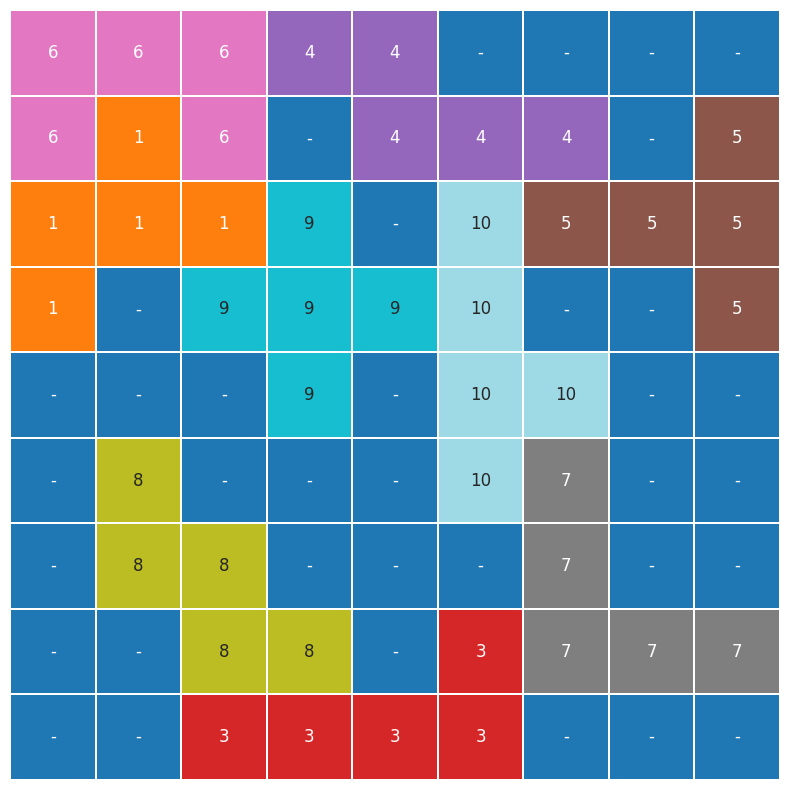

In [ ]:
# Assume N x N grid
grid = np.zeros((N, N), dtype=int)

# Fill grid from placement variables
for p, sid, shape, pi, pj in placements:
    if m.evaluate(p):  # check if this placement is selected in the solution
        for di, dj in shape:
            grid[pi + di, pj + dj] = sid + 1  # +1 so empty cells are 0

# Plot
sol_print2(grid)

## Total solve time of 450.296 seconds

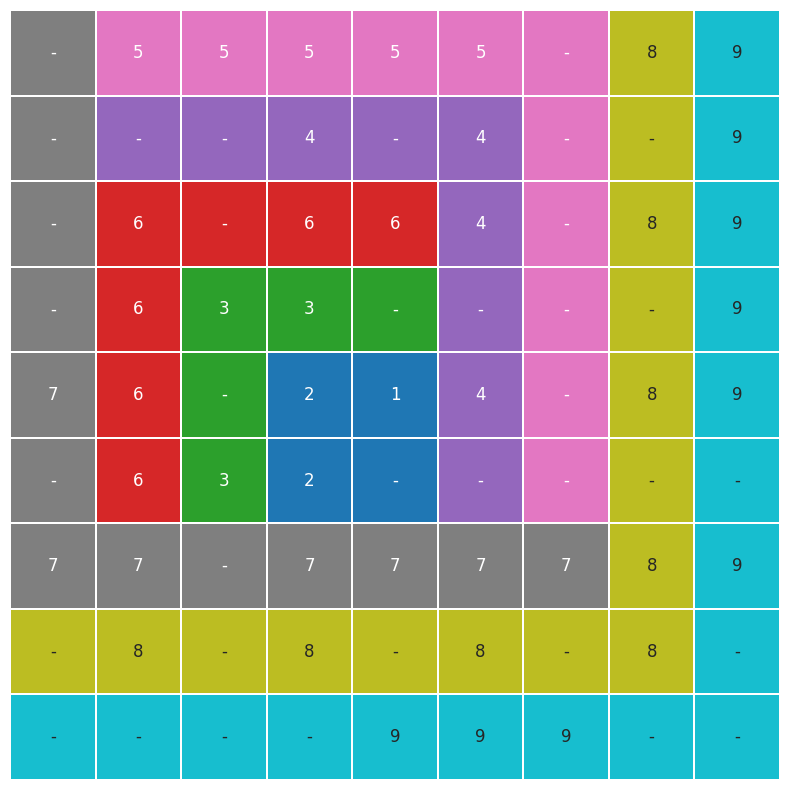

C:\Users\brian\AppData\Local\Temp\ipykernel_14880\2877243823.py:12: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, num = measurements.label(np.logical_not(grid!=0))
C:\Users\brian\AppData\Local\Temp\ipykernel_14880\2877243823.py:13: DeprecationWarning: Please import `sum` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))


## Answer is: 2,058

In [47]:
display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
sol_print(numbers=result_x, hooks=evalu(Y))
display(Markdown('## Answer is: {:,.0f}'.format((areas(result_x)))))

In [ ]:
adsf

NameError: name 'adsf' is not defined

## Total solve time of 1.323 seconds

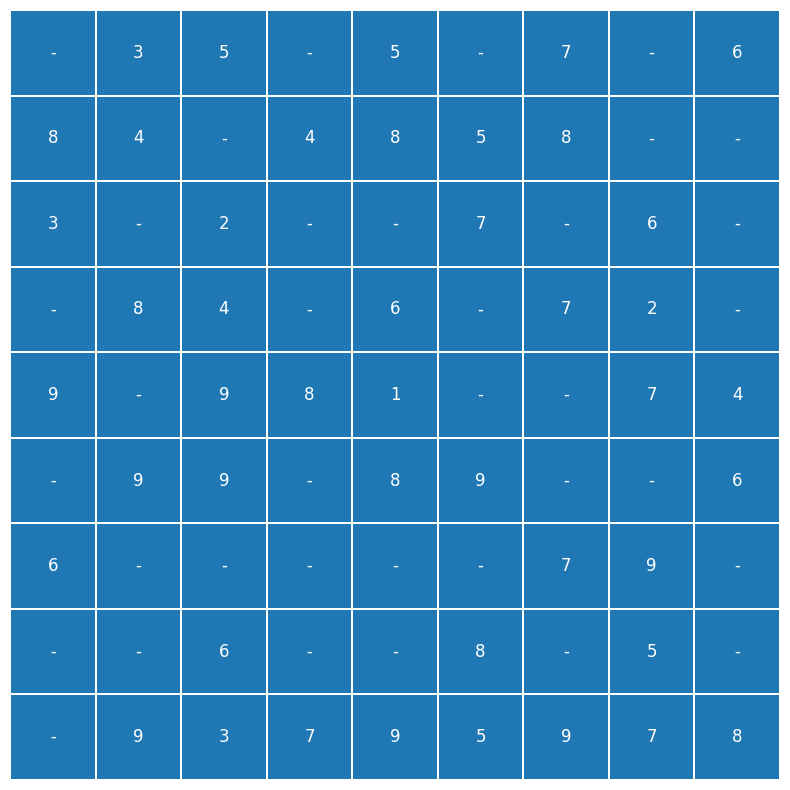

C:\Users\brian\AppData\Local\Temp\ipykernel_28416\2877243823.py:12: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, num = measurements.label(np.logical_not(grid!=0))
C:\Users\brian\AppData\Local\Temp\ipykernel_28416\2877243823.py:13: DeprecationWarning: Please import `sum` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))


## Answer is: 1,650

In [ ]:
display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
sol_print(numbers=result_x, hooks=evalu(Y))
display(Markdown('## Answer is: {:,.0f}'.format((areas(result_x)))))